# Human RT Analysis — Human-Human 2P2G and 2P3G

This notebook analyzes the focal human participant's reaction times (RT) in human–human experiments for 2-player 2-goal (2P2G) and 2-player 3-goal (2P3G) trials.

Data source: `dataAnalysis/human-human-with-gpt-fallback/combined_experiment_data.csv`.

Notes:
- Each row represents trials from one participant's export.
- `currentPlayer` indicates which role (1 or 2) this participant played.
- The focal participant's RTs are in `player1RT` when `currentPlayer == 1`, and `player2RT` when `currentPlayer == 2`.
- We focus only on rows with `partnerAgentType == 'human'` and `experimentType` in {`2P2G`, `2P3G`}.


In [1]:
import pandas as pd
import numpy as np
import ast
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
sns.set_context('talk')

data_path = Path('../dataAnalysis/human-human-with-gpt-fallback/combined_experiment_data.csv')
assert data_path.exists(), f'Missing data file: {data_path}'
df = pd.read_csv(data_path)
print('Loaded rows:', len(df))
df.head(2)

Loaded rows: 1621


,trialIndex,experimentType,partnerAgentType,currentPlayer,participantId,roomId,humanPlayerIndex,aiPlayerIndex,partnerFallbackOccurred,partnerFallbackReason,partnerFallbackStage,partnerFallbackTime,partnerFallbackAIType,collaborationSucceeded,player1GoalReachedStep,player2GoalReachedStep,newGoalPresented,newGoalPosition,distanceCondition,isNewGoalCloserToPlayer2,trialStartTime,gptErrorEvents,currentPlayerIndex,player1Trajectory,player2Trajectory,player1Actions,player2Actions,player1RT,player2RT,player1CurrentGoal,player2CurrentGoal,player1FirstDetectedGoal,player2FirstDetectedGoal,player1FinalReachedGoal,player2FinalReachedGoal,firstDetectedSharedGoal,_finalized,completed,endTime,newGoalPresentedTime,totalSteps,source_file,file_index
0,0,1P1G,none,1,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,10,-1,False,NaN,NaN,NaN,1757786781021,[],"[0,0,0,0,0,0,0,0,0,0]","[[7,10],[7,9],[7,8],[7,7],[7,6],[7,5],[6,5],[5...",[],"[[0,-1],[0,-1],[0,-1],[0,-1],[0,-1],[-1,0],[-1...",[],"[1322,1822,2433,2866,3298,3690,3954,4193,4458,...",[],"[0,0,0,0,0,0,0,0,0,0]",[],0.0,NaN,0,-1,NaN,False,True,1757786785807,NaN,10,experiment_data_5a5bd24be0cf3d000126849e_room_...,0
1,1,1P1G,none,1,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN,13,-1,False,NaN,NaN,NaN,1757786787829,[],"[0,0,0,0,0,0,0,0,0,0,0,0,0]","[[7,13],[6,13],[5,13],[4,13],[3,13],[2,13],[1,...",[],"[[-1,0],[-1,0],[-1,0],[-1,0],[-1,0],[-1,0],[-1...",[],"[1594,1938,2202,2490,2778,3098,3418,3890,4130,...",[],"[0,0,0,0,0,0,0,0,0,0,0,0,0]",[],0.0,NaN,0,-1,NaN,False,True,1757786793056,NaN,13,experiment_data_5a5bd24be0cf3d000126849e_room_...,0


In [2]:
# Filter to human-human experiments and 2P2G / 2P3G trials
mask_hh = (df['partnerAgentType'] == 'human')
mask_types = df['experimentType'].isin(['2P2G', '2P3G'])
df_hh = df.loc[mask_hh & mask_types].copy()
print('Filtered rows (human-human, 2P2G/2P3G):', len(df_hh))
display(df_hh[['participantId','roomId','experimentType','currentPlayer']].head(5))
print('Counts by experimentType:')
display(df_hh['experimentType'].value_counts())
print('Participants by experimentType:')
display(df_hh.groupby('experimentType')['participantId'].nunique())

Filtered rows (human-human, 2P2G/2P3G): 622


,participantId,roomId,experimentType,currentPlayer
747,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,1
748,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,1
749,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,1
750,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,1
751,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,1


Counts by experimentType:


experimentType
2P3G    343
2P2G    279
Name: count, dtype: int64

Participants by experimentType:


experimentType
2P2G    39
2P3G    33
Name: participantId, dtype: int64

In [3]:
# Utilities to parse JSON-like string arrays safely
def parse_array(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s == '' or s.lower() == 'nan':
        return []
    # Replace 'null' with 'None' for literal_eval compatibility
    s = s.replace('null', 'None')
    try:
        arr = ast.literal_eval(s)
    except Exception:
        # Fallback to JSON if possible
        try:
            arr = json.loads(str(x))
        except Exception:
            return []
    if isinstance(arr, (list, tuple, np.ndarray)):
        return [v for v in arr if v is not None]  # drop Nones
    return []

def get_focal_rt(row):
    cp = row.get('currentPlayer', np.nan)
    if pd.isna(cp):
        return []
    if int(cp) == 1:
        return parse_array(row.get('player1RT'))
    elif int(cp) == 2:
        return parse_array(row.get('player2RT'))
    return []

# Quick sanity check on a few rows
for i, r in df_hh.head(3).iterrows():
    print('currentPlayer', r['currentPlayer'], 'RT_len', len(get_focal_rt(r)))

currentPlayer 1 RT_len 11
currentPlayer 1 RT_len 11
currentPlayer 1 RT_len 16


In [4]:
# Build long-format RT dataframe for focal human
records = []
cols_keep = ['participantId','roomId','experimentType','trialIndex','currentPlayer']
for _, row in df_hh.iterrows():
    rts = get_focal_rt(row)
    if not rts:
        continue
    for move_i, rt_ms in enumerate(rts, start=1):
        if rt_ms is None:
            continue
        try:
            rt_val = float(rt_ms)
        except Exception:
            continue
        rec = {
            'participantId': row.get('participantId'),
            'roomId': row.get('roomId'),
            'experimentType': row.get('experimentType'),
            'trialIndex': row.get('trialIndex'),
            'currentPlayer': row.get('currentPlayer'),
            'move_index': move_i,
            'rt_ms': rt_val,
            'rt_s': rt_val / 1000.0,
        }
        records.append(rec)

rt_long = pd.DataFrame.from_records(records)
print('Long RT rows:', len(rt_long))
display(rt_long.head(10))
# Save for reuse
# out_long = Path('dataAnalysis/human_rt_long_2p2g_2p3g_hh.csv')
# rt_long.to_csv(out_long, index=False)
# print('Saved:', out_long)

Long RT rows: 8303


,participantId,roomId,experimentType,trialIndex,currentPlayer,move_index,rt_ms,rt_s
0,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,1,2441.0,2.441
1,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,2,2776.0,2.776
2,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,3,3089.0,3.089
3,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,4,3457.0,3.457
4,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,5,3897.0,3.897
5,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,6,4201.0,4.201
6,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,7,5145.0,5.145
7,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,8,5361.0,5.361
8,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,9,5633.0,5.633
9,5a5bd24be0cf3d000126849e,9922acb2-7db1-47ea-b369-ff389b4e47a5,2P2G,0,1,10,5929.0,5.929


In [5]:
# Summary statistics — all moves
summary_all = (rt_long
    .groupby('experimentType')['rt_ms']
    .agg(n='count', mean_ms='mean', median_ms='median', std_ms='std')
    .reset_index()
)
display(summary_all)
# out_summary = Path('dataAnalysis/human_rt_summary_all_moves_by_type.csv')
# summary_all.to_csv(out_summary, index=False)
# print('Saved:', out_summary)

# Participant-level means (all moves)
participant_means = (rt_long
    .groupby(['participantId','experimentType'])['rt_ms']
    .mean()
    .reset_index(name='mean_rt_ms')
)
display(participant_means.head())
# out_part = Path('dataAnalysis/human_rt_participant_means_all_moves.csv')
# participant_means.to_csv(out_part, index=False)
# print('Saved:', out_part)

,experimentType,n,mean_ms,median_ms,std_ms
0,2P2G,3575,3240.544895,2743.0,2123.638202
1,2P3G,4728,3541.513536,2764.0,3016.027887


,participantId,experimentType,mean_rt_ms
0,5723714684458100120292f6,2P2G,2502.165138
1,5723714684458100120292f6,2P3G,2517.416667
2,597519f8262c480001bbaf8b,2P2G,4428.671875
3,597519f8262c480001bbaf8b,2P3G,4540.642857
4,5a5bd24be0cf3d000126849e,2P2G,4688.022222


/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


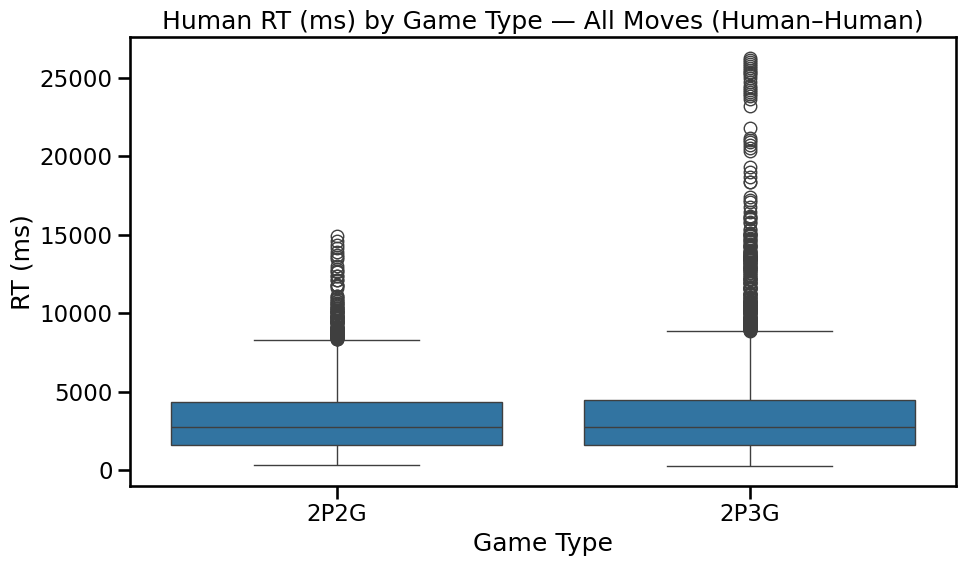

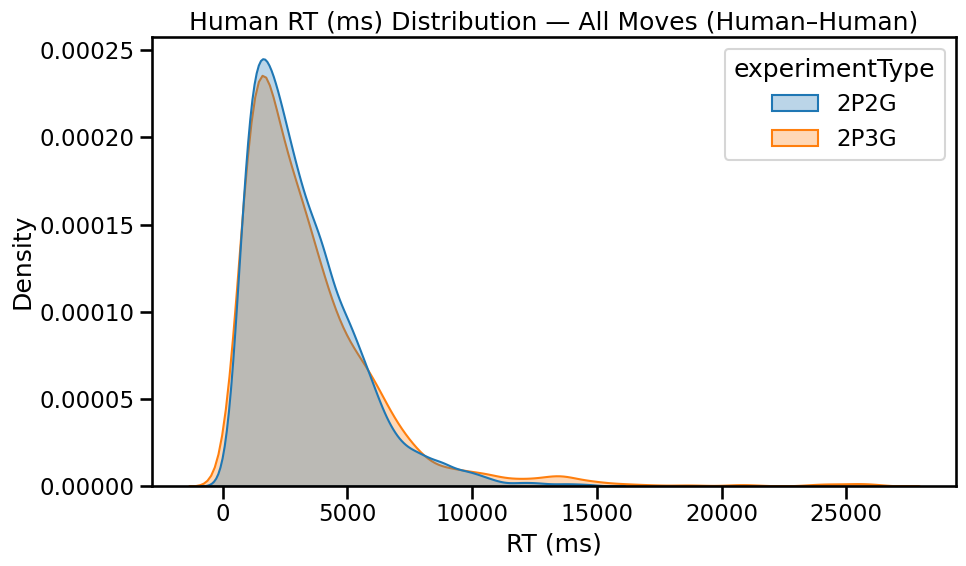

In [6]:
# Visualization — all moves
plt.figure(figsize=(10,6))
sns.boxplot(data=rt_long, x='experimentType', y='rt_ms')
plt.title('Human RT (ms) by Game Type — All Moves (Human–Human)')
plt.ylabel('RT (ms)')
plt.xlabel('Game Type')
plt.tight_layout()
# out_fig1 = Path('dataAnalysis/human_rt_boxplot_all_moves.png')
# plt.savefig(out_fig1, dpi=200)
# print('Saved:', out_fig1)
plt.show()

plt.figure(figsize=(10,6))
sns.kdeplot(data=rt_long, x='rt_ms', hue='experimentType', common_norm=False, fill=True, alpha=0.3)
plt.title('Human RT (ms) Distribution — All Moves (Human–Human)')
plt.xlabel('RT (ms)')
plt.tight_layout()
# out_fig2 = Path('dataAnalysis/human_rt_kde_all_moves.png')
# plt.savefig(out_fig2, dpi=200)
# print('Saved:', out_fig2)
plt.show()

First-move rows: 622


,participantId,roomId,experimentType,trialIndex,first_move_rt_ms,first_move_rt_s
0,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,2P2G,0,1039.0,1.039
1,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,2P2G,1,907.0,0.907
2,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,2P2G,2,926.0,0.926
3,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,2P2G,3,800.0,0.800
4,5723714684458100120292f6,329a09b2-ad1f-4458-af0b-f7dd194297d1,2P2G,4,1553.0,1.553


,experimentType,n,mean_ms,median_ms,std_ms
0,2P2G,279,1266.566308,899.0,1126.681050
1,2P3G,343,1151.763848,857.0,999.725828


/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


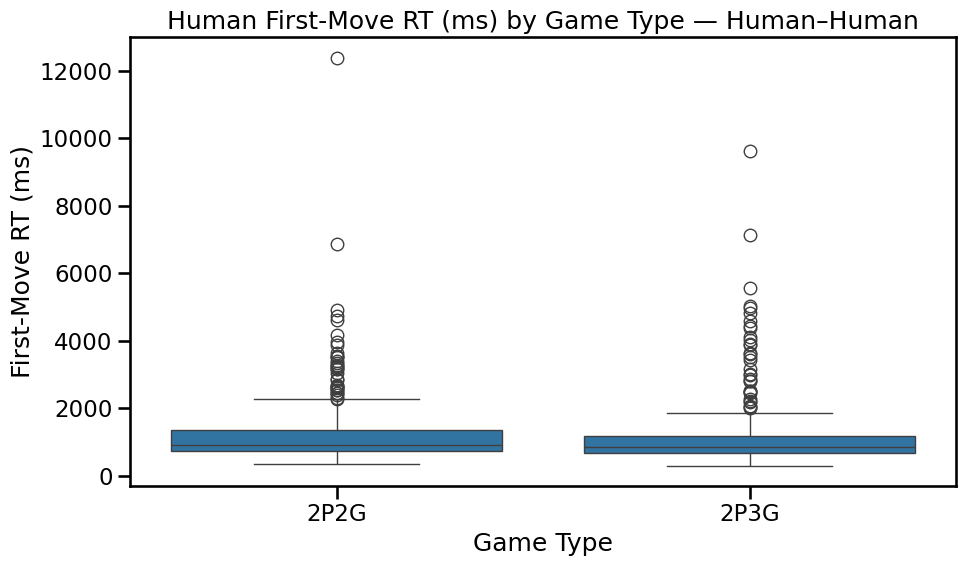

In [7]:
# First-move RT per trial (often-used RT metric)
first_move_records = []
for (pid, rid, et, ti), group in rt_long.groupby(['participantId','roomId','experimentType','trialIndex']):
    # Earliest move index for this participant in this trial
    g = group.sort_values('move_index')
    if len(g) == 0:
        continue
    fm = g.iloc[0]
    first_move_records.append({
        'participantId': pid,
        'roomId': rid,
        'experimentType': et,
        'trialIndex': ti,
        'first_move_rt_ms': fm['rt_ms'],
        'first_move_rt_s': fm['rt_ms'] / 1000.0,
    })

first_move = pd.DataFrame(first_move_records)
print('First-move rows:', len(first_move))
display(first_move.head())

fm_summary = (first_move
    .groupby('experimentType')['first_move_rt_ms']
    .agg(n='count', mean_ms='mean', median_ms='median', std_ms='std')
    .reset_index()
)
display(fm_summary)

plt.figure(figsize=(10,6))
sns.boxplot(data=first_move, x='experimentType', y='first_move_rt_ms')
plt.title('Human First-Move RT (ms) by Game Type — Human–Human')
plt.ylabel('First-Move RT (ms)')
plt.xlabel('Game Type')
plt.tight_layout()
plt.show()

## Optional: Trim outliers
If needed, apply trimming to remove extreme RTs (e.g., outside [1st, 99th] percentiles) before plotting.
Uncomment the next cell to apply trimming and regenerate visuals.

## 3σ Trim + Error Bars (Combined Means)
Mean first-move RT and inter-move RT across 2P2G and 2P3G combined, using ±3 SD trimming and SEM error bars.

,measure,mean_ms,median_ms,std_ms,sem_ms,n
0,first_move_rt_ms,1092.753289,858.5,697.812774,28.300045,608
1,inter_move_rt_ms,297.062575,208.0,243.893829,2.814180,7511


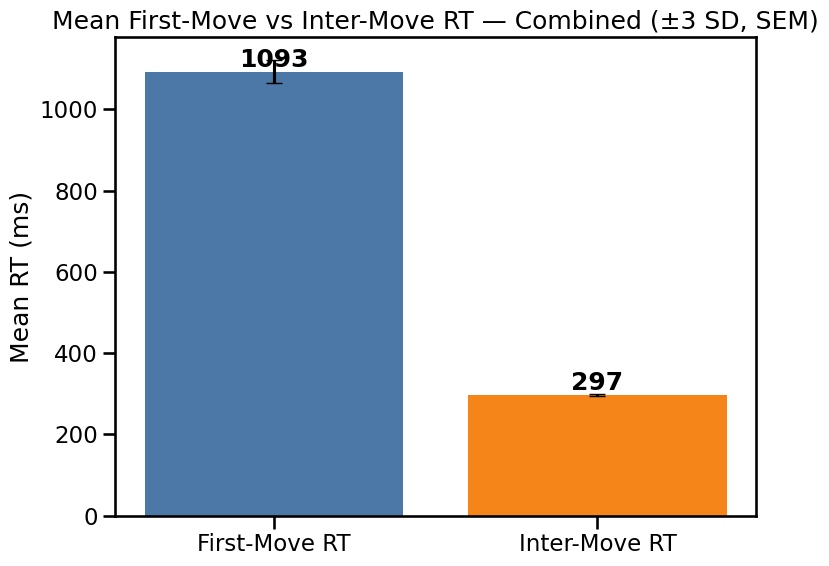

In [10]:
# Std-dev-based trimming (mean ± k*std)
def std_trim(df, col, k=3.0):
    if df is None or len(df) == 0:
        return df.copy() if df is not None else df
    m = df[col].mean()
    s = df[col].std()
    if pd.isna(s) or s == 0:
        return df.copy()
    lo, hi = m - k*s, m + k*s
    return df[(df[col] >= lo) & (df[col] <= hi)].copy()

# Build first_move if missing
if 'first_move' not in globals():
    first_move_records = []
    for (pid, rid, et, ti), group in rt_long.groupby(['participantId','roomId','experimentType','trialIndex']):
        g = group.sort_values('move_index')
        if len(g) == 0:
            continue
        fm = g.iloc[0]
        first_move_records.append({
            'participantId': pid, 'roomId': rid, 'experimentType': et, 'trialIndex': ti,
            'first_move_rt_ms': fm['rt_ms'], 'first_move_rt_s': fm['rt_ms']/1000.0,
        })
    first_move = pd.DataFrame(first_move_records)

# Build inter-move if missing
if 'imrt_long' not in globals():
    parts = []
    for keys, g in rt_long.groupby(['participantId','roomId','experimentType','trialIndex']):
        g = g.sort_values('move_index').copy()
        g['inter_rt_ms'] = g['rt_ms'].diff()
        g['inter_move_index'] = g['move_index']
        gg = g[g['inter_rt_ms'].notna() & (g['inter_rt_ms'] > 0)].copy()
        if len(gg) == 0:
            continue
        gg['inter_rt_s'] = gg['inter_rt_ms'] / 1000.0
        parts.append(gg[['participantId','roomId','experimentType','trialIndex','inter_move_index','inter_rt_ms','inter_rt_s']])
    imrt_long = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=['participantId','roomId','experimentType','trialIndex','inter_move_index','inter_rt_ms','inter_rt_s'])

# Apply ±3 SD trim
fm_src = std_trim(first_move, 'first_move_rt_ms', 3.0)
imrt_src = std_trim(imrt_long, 'inter_rt_ms', 3.0)

def sem(series):
    return series.std() / np.sqrt(len(series)) if series is not None and len(series)>0 else np.nan

combined_stats_std = pd.DataFrame([
    { 'measure': 'first_move_rt_ms', 'mean_ms': fm_src['first_move_rt_ms'].mean(), 'median_ms': fm_src['first_move_rt_ms'].median(), 'std_ms': fm_src['first_move_rt_ms'].std(), 'sem_ms': sem(fm_src['first_move_rt_ms']), 'n': len(fm_src) },
    { 'measure': 'inter_move_rt_ms', 'mean_ms': imrt_src['inter_rt_ms'].mean(), 'median_ms': imrt_src['inter_rt_ms'].median(), 'std_ms': imrt_src['inter_rt_ms'].std(), 'sem_ms': sem(imrt_src['inter_rt_ms']), 'n': len(imrt_src) },
])
display(combined_stats_std)

# Save CSV
# out_combined_std_csv = Path('dataAnalysis/human_rt_mean_first_vs_inter_combined_stdtrim_sem.csv')
# combined_stats_std.to_csv(out_combined_std_csv, index=False)
# print('Saved:', out_combined_std_csv)

# Bar plot with SEM error bars
plt.figure(figsize=(8,6))
labels = ['First-Move RT', 'Inter-Move RT']
means = [combined_stats_std.loc[combined_stats_std.measure=='first_move_rt_ms','mean_ms'].iloc[0],
          combined_stats_std.loc[combined_stats_std.measure=='inter_move_rt_ms','mean_ms'].iloc[0]]
sems = [combined_stats_std.loc[combined_stats_std.measure=='first_move_rt_ms','sem_ms'].iloc[0],
        combined_stats_std.loc[combined_stats_std.measure=='inter_move_rt_ms','sem_ms'].iloc[0]]
bars = plt.bar(labels, means, yerr=sems, capsize=6, color=['#4C78A8','#F58518'])
plt.ylabel('Mean RT (ms)')
plt.title('Mean First-Move vs Inter-Move RT — Combined (±3 SD, SEM)')
for b, v in zip(bars, means):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), f'{v:.0f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
# out_combined_std_fig = Path('dataAnalysis/human_rt_mean_first_vs_inter_combined_stdtrim_sem.png')
# plt.savefig(out_combined_std_fig, dpi=200)
# print('Saved:', out_combined_std_fig)
plt.show()

## 3σ Trimmed Boxplots
First-move and inter-move RT by game type, trimmed at ±3 SD.

/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


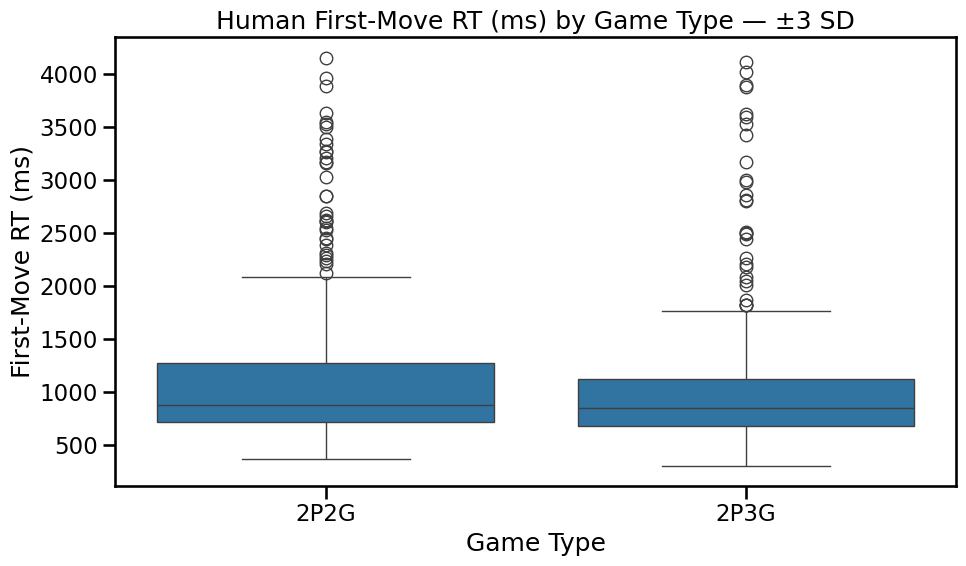

/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/opt/anaconda3/lib/python3.12/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


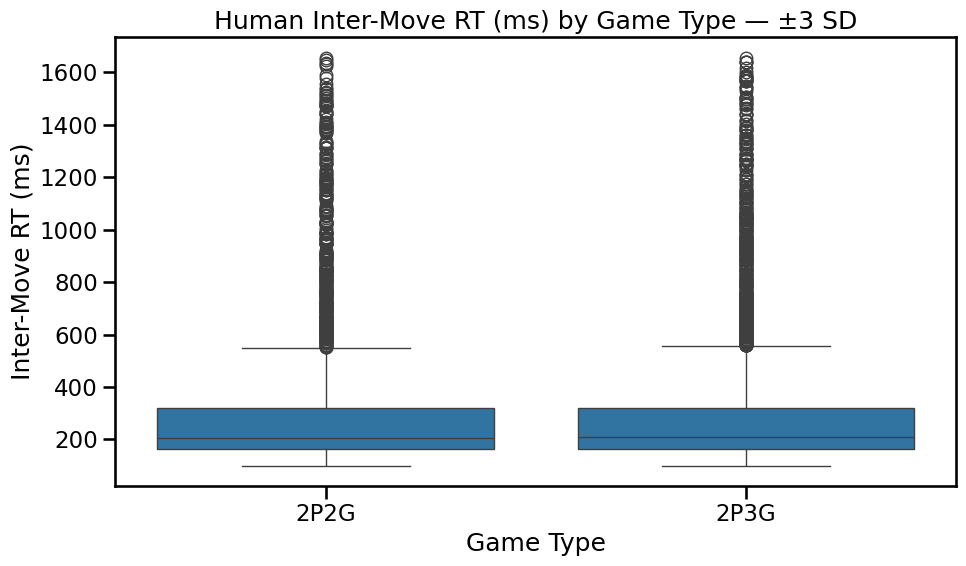

In [11]:
# First-move boxplot (±3 SD)
fm_plot = std_trim(first_move, 'first_move_rt_ms', 3.0)
plt.figure(figsize=(10,6))
sns.boxplot(data=fm_plot, x='experimentType', y='first_move_rt_ms')
plt.title('Human First-Move RT (ms) by Game Type — ±3 SD')
plt.ylabel('First-Move RT (ms)')
plt.xlabel('Game Type')
plt.tight_layout()
# out_fig_fm = Path('dataAnalysis/human_rt_first_move_boxplot_stdtrim.png')
# plt.savefig(out_fig_fm, dpi=200)
# print('Saved:', out_fig_fm)
plt.show()

# Inter-move boxplot (±3 SD)
# Build imrt_long from rt_long if needed
if 'imrt_long' not in globals():
    parts = []
    for keys, g in rt_long.groupby(['participantId','roomId','experimentType','trialIndex']):
        g = g.sort_values('move_index').copy()
        g['inter_rt_ms'] = g['rt_ms'].diff()
        g['inter_move_index'] = g['move_index']
        gg = g[g['inter_rt_ms'].notna() & (g['inter_rt_ms'] > 0)].copy()
        if len(gg) > 0:
            gg['inter_rt_s'] = gg['inter_rt_ms'] / 1000.0
            parts.append(gg[['participantId','roomId','experimentType','trialIndex','inter_move_index','inter_rt_ms','inter_rt_s']])
    imrt_long = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=['participantId','roomId','experimentType','trialIndex','inter_move_index','inter_rt_ms','inter_rt_s'])

imrt_plot = std_trim(imrt_long, 'inter_rt_ms', 3.0)
plt.figure(figsize=(10,6))
sns.boxplot(data=imrt_plot, x='experimentType', y='inter_rt_ms')
plt.title('Human Inter-Move RT (ms) by Game Type — ±3 SD')
plt.ylabel('Inter-Move RT (ms)')
plt.xlabel('Game Type')
plt.tight_layout()
# out_fig_im = Path('dataAnalysis/human_inter_move_rt_boxplot_stdtrim.png')
# plt.savefig(out_fig_im, dpi=200)
# print('Saved:', out_fig_im)
plt.show()